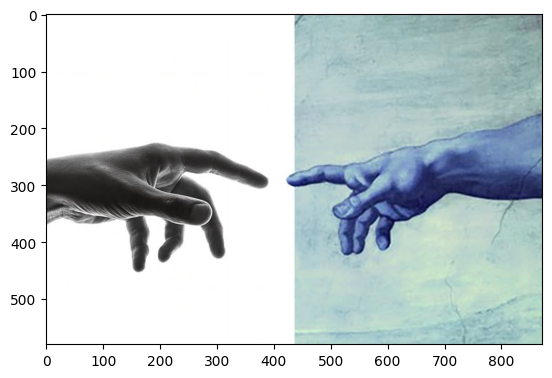

In [18]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread("images/posing-hands.jpg")
plt.imshow(img)

c:\Users\Ivan\Documents\CMA\ML Parkinsons Repository\Parkinson-Prediagnosis\Instruct\CV_Hand_Model\venv\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


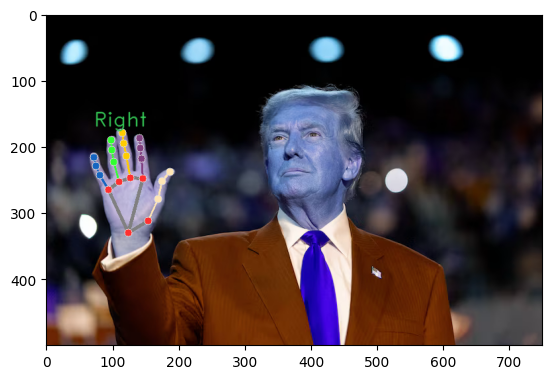

In [2]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from utils.draw_landmarks import draw_landmarks_on_image

# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 3: Load the input image.
img = cv2.imread("images/img1.png")

# STEP 3.5: Convert to Mediapip with RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = mp.Image(image_format=mp.ImageFormat.SRGB, data=img)

# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(img)

# STEP 5: Process the classification result. In this case, visualize it.
# Function to draw landmarks on the image
#@markdown We implemented some functions to visualize the hand landmark detection results. <br/> Run the following cell to activate the functions.


annotated_image = draw_landmarks_on_image(img.numpy_view(), detection_result)
annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)

plt.imshow(annotated_image)

In [1]:
import cv2
import mediapipe as mp
import pandas as pd
from mediapipe.tasks.python import vision
from utils.draw_landmarks import draw_landmarks_on_image  # Import the function

# Create a HandLandmarker object
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

video_path = "images/IMG_1906.mp4"
cap = cv2.VideoCapture(video_path)

landmarks_data = []

frame_number = 0  # To keep track of frame number
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print(f"Processing Video...")
        break

    # Convert frame to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Convert to Mediapipe
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)

    # Detect hand landmarks from the input image
    detection_result = detector.detect(mp_image)

    # Process the classification result
    annotated_frame = draw_landmarks_on_image(frame_rgb, detection_result)
    
    # Extract landmarks
    if detection_result.hand_landmarks:
        for hand_landmarks in detection_result.hand_landmarks:
            for idx, landmark in enumerate(hand_landmarks):
                landmarks_data.append({
                    'Frame': frame_number,
                    'Landmark Index': idx,
                    'X': landmark.x,
                    'Y': landmark.y,
                    'Z': landmark.z
                })

    # Display the annotated frame
    annotated_frame_bgr = cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR)
    cv2.imshow('Hand Landmarks', annotated_frame_bgr)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_number += 1

cap.release()
cv2.destroyAllWindows()

# Create DataFrame
 df = pd.DataFrame(landmarks_data)
 print(df)


NameError: name 'python' is not defined

In [8]:
df.to_csv('landmarks_data.csv', index=False)  # Save DataFrame to CSV

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Frame           9471 non-null   int64  
 1   Landmark Index  9471 non-null   int64  
 2   X               9471 non-null   float64
 3   Y               9471 non-null   float64
 4   Z               9471 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 370.1 KB


# Computing Change in Velocity from Generated Video df

In [26]:
fps = 30
time_per_frame = 1/fps

# Convert values to float
#df['X'] = df['X'].astype(float)
#df['Y'] = df['Y'].astype(float)
#df['Z'] = df['Z'].astype(float)

# Sort the df by landmark index
df = df.sort_values(by=['Frame', 'Landmark Index'])

# Calcualte the displacement by frame of landmark index
df['dX'] = df.groupby('Landmark Index')['X'].diff()
df['dY'] = df.groupby('Landmark Index')['Y'].diff()
df['dZ'] = df.groupby('Landmark Index')['Z'].diff()

# Calculate magnitude of displcemnt in 3d space
df['Velocity'] = np.sqrt(df['dX']**2 + df['dY']**2 + df['dZ']**2)/ time_per_frame

df = df.dropna()



<class 'pandas.core.frame.DataFrame'>
Index: 9429 entries, 42 to 9470
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Frame           9429 non-null   int64  
 1   Landmark Index  9429 non-null   int64  
 2   X               9429 non-null   float64
 3   Y               9429 non-null   float64
 4   Z               9429 non-null   float64
 5   dX              9429 non-null   float64
 6   dY              9429 non-null   float64
 7   dZ              9429 non-null   float64
 8   Velocity        9429 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 736.6 KB


<function matplotlib.pyplot.show(close=None, block=None)>

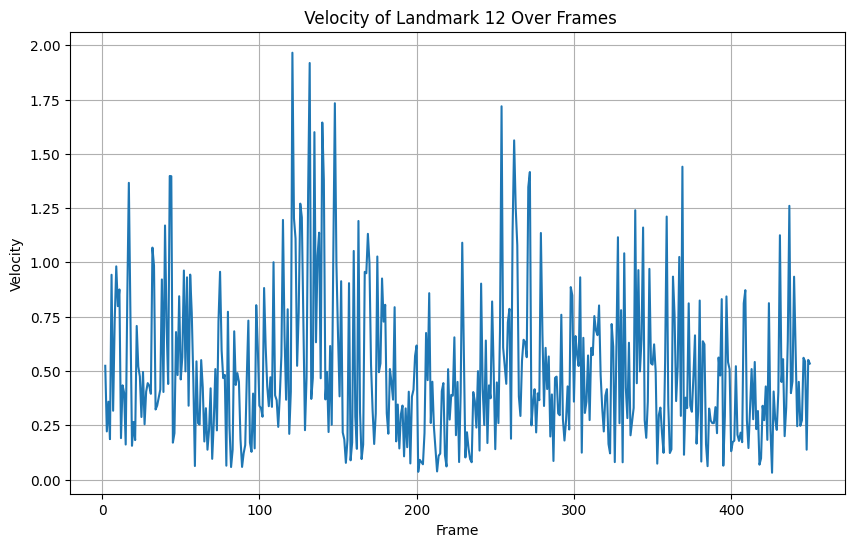

In [35]:
# BASIC GRAPH
import matplotlib.pyplot as plt

landmark_index = 12

landmark_data = df[df['Landmark Index'] == landmark_index]

plt.figure(figsize=(10,6))
plt.plot(landmark_data['Frame'], landmark_data['Velocity'], label=f'Landmark {landmark_index}')
plt.xlabel('Frame')
plt.ylabel('Velocity')
plt.title(f' Velocity of Landmark {landmark_index} Over Frames')
plt.grid(True)

plt.show

C:\Users\Ivan\AppData\Local\Temp\ipykernel_22892\2506310203.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  landmark_data['Moving_Average'] = landmark_data['Velocity'].rolling(window=window_size).mean()


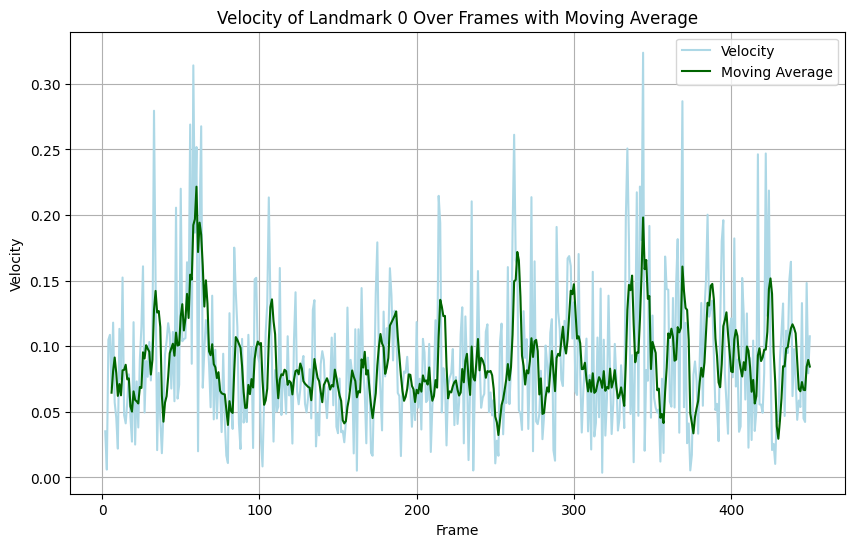

In [38]:
# GRAPH WITH AVERAGE

def plot_velocity_with_moving_average(df, landmark_index, window_size=5):
    """
    Plots the velocity of a specified landmark over frames with a moving average trendline.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        landmark_index (int): The index of the landmark to plot.
        window_size (int): The size of the moving average window.
    """
    # Filter the DataFrame for the selected landmark
    landmark_data = df[df['Landmark Index'] == landmark_index]

    # Calculate moving average
    landmark_data['Moving_Average'] = landmark_data['Velocity'].rolling(window=window_size).mean()

    # Plot velocity and moving average
    plt.figure(figsize=(10, 6))
    plt.plot(landmark_data['Frame'], landmark_data['Velocity'], label='Velocity', color='lightblue')
    plt.plot(landmark_data['Frame'], landmark_data['Moving_Average'], label='Moving Average', color='darkgreen', linestyle='-')

    # Add labels and title
    plt.xlabel('Frame')
    plt.ylabel('Velocity')
    plt.title(f'Velocity of Landmark {landmark_index} Over Frames with Moving Average')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

# Example usage
plot_velocity_with_moving_average(df, landmark_index=0)  # Replace 0 with your desired landmark index


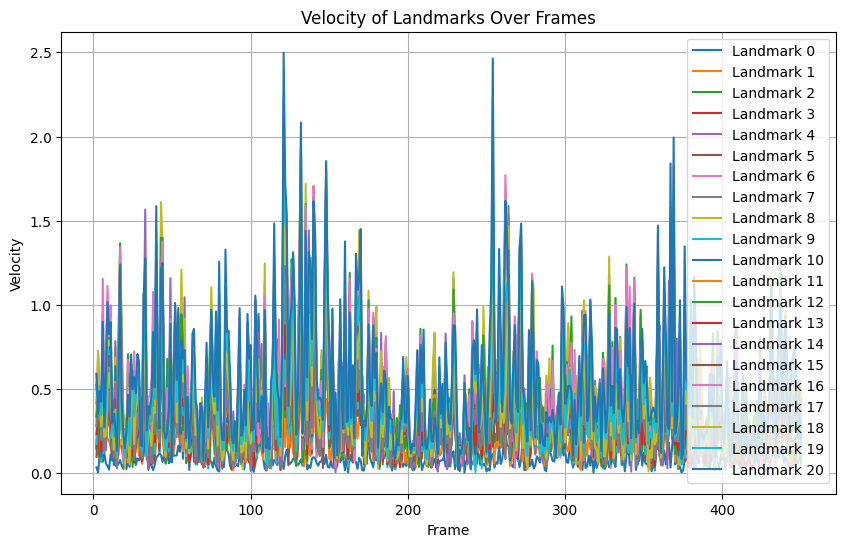

In [31]:
# ALL LANDMARKS

# Plot velocity for each landmark
plt.figure(figsize=(10, 6))

# Loop through each landmark and plot its velocity
for landmark in df['Landmark Index'].unique():
    landmark_data = df[df['Landmark Index'] == landmark]
    plt.plot(landmark_data['Frame'], landmark_data['Velocity'], label=f'Landmark {landmark}')

# Add labels and title
plt.xlabel('Frame')
plt.ylabel('Velocity')
plt.title('Velocity of Landmarks Over Frames')
plt.legend()  # Add a legend to differentiate between landmarks
plt.grid(True)

# Show the plot
plt.show()
